# HIRES retrievals with [JAX](https://github.com/google/jax)
Brett Morris & Jens Hoeijmakers


This is a fork of Brett's retrieval demo, applied to high resolution transmission spectra, providing a proof of concept.

In [126]:
%matplotlib inline
# We need to import numpyro first, though we use it last
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp


# Set the number of cores on your machine for parallelism:
cpu_cores = 4
numpyro.set_host_device_count(cpu_cores)

# From jax, we'll import the numpy module as `jnp`
from jax import numpy as jnp

### Loading an opacity grid.
An opacity function of Fe is located in the `opacity/VALD_2600e2` folder. We load it using a binary IO script packaged in `tayph`.

In [127]:
def read_binary_kitzmann(inpath,double=True):
    """This reads a binary model spectrum (those created by Daniel Kitzmann)
    located at path inpath."""
    import struct
    if double == True:
        nbytes = 8
        tag = 'd'
    else:
        nbytes = 4
        tag = 'f'
    r = []

    f = open(inpath,'rb')
    while True:
        seq = f.read(nbytes)
        if not seq:
            break
        else:
            r.append(struct.unpack(tag,seq)[0])#I put an index here because it was making a list of tuples.
            #I hope that this still works when double=True!
    f.close()
    return(r)


k_Fe = jnp.array(read_binary_kitzmann('opacity/VALD_2600e2/Out_00000_60000_03000_n800.bin',double=False))
k_wn = jnp.arange(len(k_Fe))*1e-2
k_wl = 1e7/k_wn

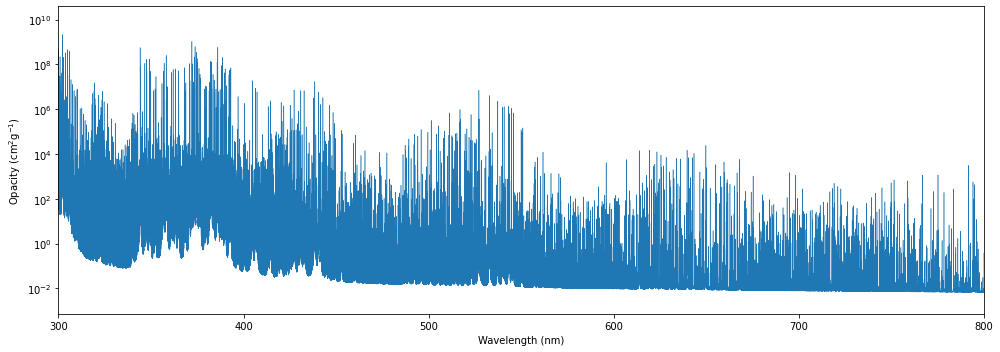

In [128]:
plt.figure(figsize=(14,5))
plt.plot(k_wl,k_Fe,linewidth=0.5)
plt.yscale('log')
plt.xlim(300,800)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Opacity (cm$^2$g$^{-1}$)')
plt.tight_layout()
plt.show()

### Interpolating the opacity function onto the data wavelength array.

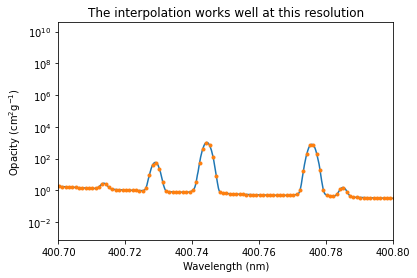

In [129]:
# Create a linearly spaced `DeviceArray` object, which is going to be our wavelength array.
wl = jnp.linspace(380, 500, 120_000)#60,000 points on a 60nm bandpass == 300k points on a 300nm bandpass.


k_Fe_i = interp.interp1d(k_wl,k_Fe)(wl)#This interpolation is done once, assuming that no resolving power is lost.


plt.plot(k_wl,k_Fe)
plt.plot(wl,k_Fe_i,'.')
plt.xlim(400.7,400.8)
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.title("The interpolation works well at this resolution")
plt.ylabel('Opacity (cm$^2$g$^{-1}$)')
plt.show()

### Creating a synthetic dataset 
We will use the analytical formula of [Heng & Kitzmann 2017](http://adsabs.net/abs/2017MNRAS.470.2972H) as a model for our transmission spectrum. We will use three free parameters: T, chi_Fe and kappa_0, which are the temperature, the abundance of Fe and the (flat) continuum opacity.
<br><br>
Declare a bunch of constants to define our planet:

In [131]:

import astropy.constants as const
import astropy.units as u
gamma = 0.57721
RJ = const.R_jup.cgs.value
MJ = const.M_jup.cgs.value
G = const.G.cgs.value
Rsun = const.R_sun.cgs.value


P0 = (1.0*u.bar).cgs.value#bar
R0 = 1.8*RJ
M0 = 1.2*MJ
k = const.k_B.cgs.value
m = 2.33*const.u.cgs.value
Rs = 1.4*Rsun
g = G*M0 / R0**2


<br>
<br>
Then we define the spectral model. The free parameters are wrapped in p, as temperature, Fe abundance, constant opacity and a constant to renormalise the spectrum.

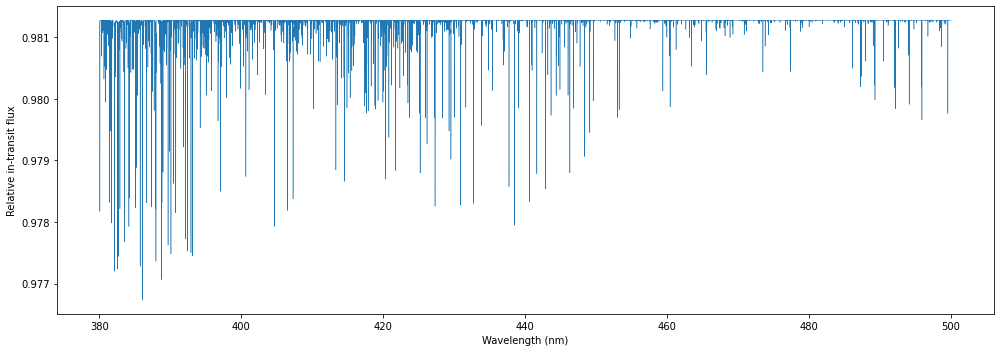

In [132]:
def model_numpy(p, x):
    """Numpy implementation of H&K 2017"""
    T,logchi,logk0,c = p 
    H = k*T/m/g
    K = 10**logchi*x+10**logk0#The total opacity is the vmr of Fe plus the constant gray haze.
    #Note that we supply the logarithms of chi and k0 as free parameters, because these have large dynamic range.
    #This also implicitly constrains them to positive values.
    R = R0 + H*(gamma+np.log(P0 * K / g * np.sqrt(2*np.pi*R0/H) ) )
    return (c-R**2 / Rs**2)

plt.figure(figsize=(14,5))
plt.plot(wl,model_numpy([3000.0,-6,-3,1.0],k_Fe_i),linewidth=0.5)
plt.xlabel('Wavelength (nm)');
plt.ylabel('Relative in-transit flux')
plt.tight_layout()
plt.show()

<br><br>
Now we turn this into something that looks like data, by adding noise:

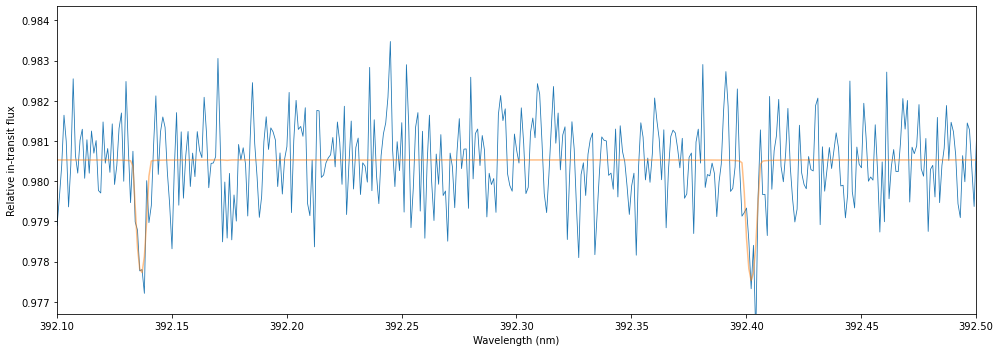

In [133]:
np.random.seed(42)

true_p = [3100.0,-6.2,-2.1,1.0]

SNR = 1000.0
x = wl
y1 = model_numpy(true_p,k_Fe_i)
yerr = 1.0/SNR
y = y1 + np.random.normal(scale=yerr, size=(len(x)))

yrange = np.max([3*yerr,np.abs(np.max(y1)-np.min(y1))])

plt.figure(figsize=(14,5))
plt.plot(x, y,linewidth=0.8)
plt.plot(x,y1,alpha=0.5)
plt.xlim(392.1,392.5)
plt.ylim(np.mean(y)-yrange,np.mean(y)+yrange)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative in-transit flux')
plt.tight_layout()
plt.show()

### Fitting with numpy/scipy

We could fit the observations $(x, y)$ with numpy and scipy like this: 

In [134]:
# From scipy, we'll import the Powell minimizer
from scipy.optimize import fmin_powell

def chi2_numpy(p, x, y, yerr):
    """chi^2 function to minimize, using numpy/scipy"""
    return np.sum((model_numpy(p, x) - y)**2 / yerr**2)



init_guess_numpy = np.array([2800, -5.5, -3.0, 1.000])
best_p_numpy = fmin_powell(chi2_numpy, init_guess_numpy, disp=0, args=(k_Fe_i, y, yerr))

print('Initial values:')
print(init_guess_numpy)
print('Best fit:')
print(best_p_numpy)
print('True values:')
print(true_p)

Initial values:
[ 2.8e+03 -5.5e+00 -3.0e+00  1.0e+00]
Best fit:
[ 4.82834871e+03 -7.84291530e+00 -2.93541412e+00  1.00000030e+00]
True values:
[3100.0, -6.2, -2.1, 1.0]


The best fit looks like this:

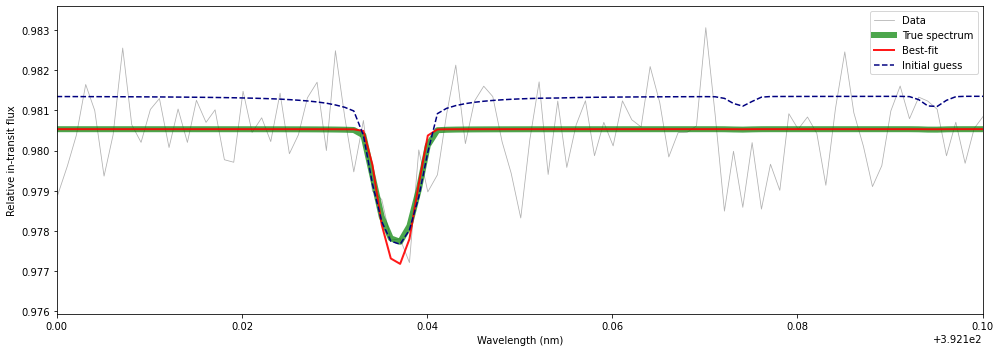

In [135]:
plt.figure(figsize=(14,5))
plt.plot(x, y,linewidth=0.8,color='black',label='Data',alpha=0.3)#This is the data
plt.plot(x,y1,alpha=0.7,label='True spectrum',color='green',linewidth=6)
plt.plot(x,model_numpy(best_p_numpy, k_Fe_i),alpha=0.9,label='Best-fit',color='red',linewidth=2)
plt.plot(x,model_numpy(init_guess_numpy, k_Fe_i),alpha=1,label='Initial guess',color='navy',linestyle='--')
plt.xlim(392.1,392.2)
plt.ylim(np.mean(y)-yrange*1.2,np.mean(y)+yrange*0.8)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative in-transit flux');
plt.legend()
plt.tight_layout()
plt.show()

The initial guess is shown above in blue, and the best-fit model using numpy/scipy is shown in red. If the initial guess is good, the best-fit model will be quite close to the true input model. However, this depends strongly on the initial parameters and the noise. Changing the temperature by ~500 K or changing the Fe abundance or haze opacity by a few orders of magnitude will drastically worsen the fit.

### Fitting with jax

Let's specify the model that we will fit to the data using the numpy module within jax. We'll also "decorate" it with the `jit` decorator, which will compile the function for us at runtime. 

In [136]:
# Get the just-in-time decorator
from jax import jit

@jit
def model_jax(p, x):     
    """
    Jax implementation of the `model_numpy` function.
    
    The use of `jnp` in place of `np` is the only difference 
    from the numpy version.
    """
    T,logchi,logk0,c = p 
    H = k*T/m/g
    K = 10**logchi*x+10**logk0#The total opacity is the vmr of Fe plus the constant gray haze.
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    return (c-R**2 / Rs**2)

@jit
def chi2_jax(p, x, y, yerr):
    """chi^2 function written for minimization with jax"""
    return jnp.sum((model_jax(p, x) - y)**2 / yerr**2)

Now we import the minimize module from the `scipy.optimize` API within jax: 

Best fit:
[ 2.9971265e+03 -4.5092954e+03  4.3327402e+03  3.8098097e-01]
True values:
[3100.0, -6.2, -2.1, 1.0]
Initial guess:
[ 3.e+03 -6.e+00 -4.e+00  1.e+00]
Did the fit succeed?!
False


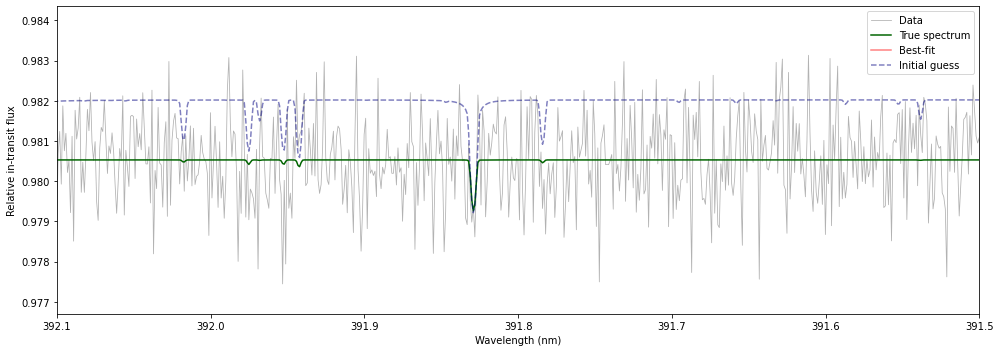

In [137]:
# Jax has its own scipy module which uses autodiffed gradients
from jax.scipy.optimize import minimize

init_guess = np.array([3000.0, -6, -4,1.0])
bestp_jax = minimize(chi2_jax, init_guess, args=(jnp.array(k_Fe_i), jnp.array(y), yerr), method='bfgs')

# print the best-fit parameters
print('Best fit:')
print(bestp_jax.x)
print('True values:')
print(true_p)
print('Initial guess:')
print(init_guess)

print('Did the fit succeed?!')
print(bestp_jax.success)

plt.figure(figsize=(14,5))
plt.plot(x, y,linewidth=0.8,color='black',label='Data',alpha=0.3)#This is the data
plt.plot(x,y1,alpha=1.0,label='True spectrum',color='darkgreen')
plt.plot(x,model_jax(bestp_jax.x, k_Fe_i),alpha=0.5,label='Best-fit',color='red')
plt.plot(x,model_jax(init_guess, k_Fe_i),alpha=0.5,label='Initial guess',color='navy',linestyle='--')
plt.xlim(392.1,391.5)
plt.ylim(np.mean(y)-yrange,np.mean(y)+yrange)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative in-transit flux');
plt.legend()
plt.tight_layout()
plt.show()

Unfortunately, this fit is extremely bad. The reason is that there is a strong degeneracy between the value of the continuum opacity `k0` and the constant offset of the spectrum. This degeneracy can, in principle, be broken by sampling more spectral lines and having a higher SNR; because there is a qualitative difference in the effects of `c` and `k0`. However, be best-fit parameters for `chi`, `k0` and are `c` also unphysical: We will need priors on these parameters to box in the solution and guide the minimizer in the right direction.

### Posterior inference with jax/numpyro

Now let's infer posterior distributions for the parameters using more complex inference methods, using _numpyro_. We will define a _model_ which specifies _distributions_ that represent each parameter:

In [138]:
def numpyro_model():
    """
    Define a model to sample with the No U-Turn Sampler (NUTS) via numpyro.
    
    The two Gaussians are defined by an amplitude, mean, and standard deviation.
    
    To find unique solutions for the two Gaussians, we put non-overlapping bounded 
    priors on the two amplitudes, but vary the means and stddev's with identical 
    uniform priors. 
    """
    # Define a prior for the temperature:
    T_prior = numpyro.sample('T', dist.Uniform(low=1000, high=6000))
    
    # Uniform prior for log(chi)
    chi_prior = numpyro.sample(
        'log($\chi_{Fe}$)', dist.Uniform(low=-10, high=-3))
    
    # Uniform prior for log(k0):
    k0_prior = numpyro.sample('log($\kappa_0$)', dist.Uniform(low=-5, high=0))

#     Uniform prior for log(k0):
#     c_prior = numpyro.sample('c', dist.Normal(loc=1.0, scale=0.001))
    c_prior = numpyro.sample('c', dist.Uniform(low=0.999, high=1.001))
    
    # Normally distributed likelihood
    numpyro.sample("obs", dist.Normal(loc=model_jax([T_prior, chi_prior, k0_prior,c_prior], k_Fe_i),scale=yerr), obs=y)

The above cell defines the model. Now the cell below defines how to sample the model, and runs the sampler.

In [93]:
# Random numbers in jax are generated like this:
from jax.random import PRNGKey, split

rng_seed = 42
rng_keys = split(PRNGKey(rng_seed),cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=200, 
    num_samples=1800, 
    num_chains=4
)

# Run the MCMC
mcmc.run(rng_keys)

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

W0609 23:30:32.339613 140734981461440 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.
W0609 23:30:32.344927 140734981461440 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.
W0609 23:30:32.348795 140734981461440 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.


Here you will likely see that some chains are slow. This is because the problem is extremely degenerate in `k0`, `chi` and `c`, due to the abundance and normalisation degeneracies. However, the posterior does start to look like something!
<br><br>
Let's visualize the posteriors using `arviz` and `corner`:

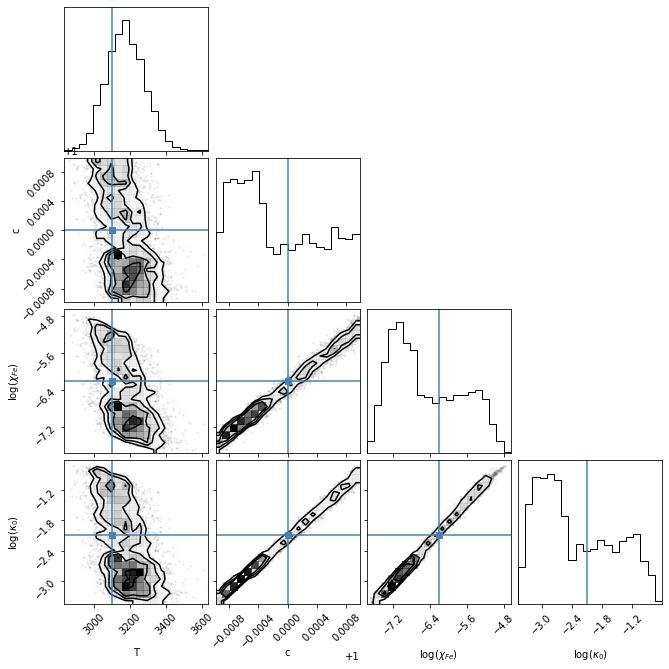

In [96]:
# these packages will aid in visualization:
import arviz
from corner import corner

# arviz converts a numpyro MCMC object to an `InferenceData` object based on xarray:
result = arviz.from_numpyro(mcmc)

# these are the inputs to the synthetic double-gaussian profile (blue lines)
truths = {'T': true_p[0], 'log($\chi_{Fe}$)': true_p[1], 'log($\kappa_0$)': true_p[2], 'c': true_p[3]}
# make a corner plot
corner(
    result, 
    quiet=True, 
    truths=truths
);

Note how all posterior distributions contain the "true" value, despite strong degeneracy in `c`, `k0` and `chi`.

To make this better, we can do two things. First of all, we can add more species. Having more spectral lines to work with, will force the algorithm to see the difference between the effects of `k0`, `c` and `chi`. Secondly, we can add the abundances of additional species as parameters relative to Fe. This will allow us to retrieve abundance ratios, which should be much more accurate (because they suffer from the same degeneracy as Fe), than absolute abundances.

<br><br>
We are going read opacities of Ti, V and Cr for this and interpolate them onto the data wl array.

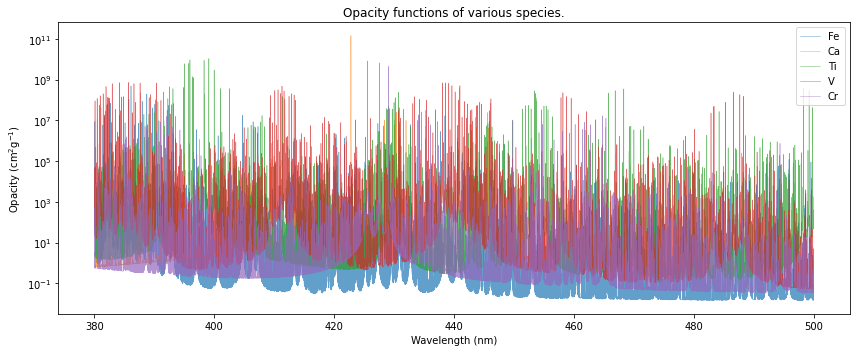

In [145]:
k_Ca = jnp.array(read_binary_kitzmann('opacity/VALD_2000e2/Out_00000_60000_02500_n800.bin',double=False))
k_Ti = jnp.array(read_binary_kitzmann('opacity/VALD_2200e2/Out_00000_60000_02500_n800.bin',double=False))
k_V = jnp.array(read_binary_kitzmann('opacity/VALD_2300e2/Out_00000_60000_02500_n800.bin',double=False))
k_Cr = jnp.array(read_binary_kitzmann('opacity/VALD_2400e2/Out_00000_60000_02500_n800.bin',double=False))

k_Ca_i = interp.interp1d(k_wl,k_Ca)(wl)
k_Ti_i = interp.interp1d(k_wl,k_Ti)(wl)#This interpolation is done once, assuming that no resolving power is lost.
k_V_i = interp.interp1d(k_wl,k_V)(wl)
k_Cr_i = interp.interp1d(k_wl,k_Cr)(wl)

plt.figure(figsize=(12,5))
plt.plot(wl,k_Fe_i,label='Fe',linewidth=0.5,alpha=0.7)
plt.plot(wl,k_Ca_i,label='Ca',linewidth=0.5,alpha=0.7)
plt.plot(wl,k_Ti_i,label='Ti',linewidth=0.5,alpha=0.7)
plt.plot(wl,k_V_i,label='V',linewidth=0.5,alpha=0.7)
plt.plot(wl,k_Cr_i,label='Cr',linewidth=0.5,alpha=0.7)
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.title("Opacity functions of various species.")
plt.ylabel('Opacity (cm$^2$g$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.show()

Now we need to re-define the jax model, to include the additional free parameters given by the added species.

In [153]:
@jit
def model_jax_adv(p, x1,x2,x3,x4,x5):     
    """
    Jax implementation of the `model_numpy` function.
    
    The use of `jnp` in place of `np` is the only difference 
    from the numpy version.
    """
    T,logchi_fe,logratio_cafe,logratio_tife,logratio_vfe,logratio_crfe,logk0,c = p 
    H = k*T/m/g
    K = 10**logchi_fe*(x1+10**logratio_cafe*x2+10**logratio_tife*x3+10**logratio_vfe*x4+10**logratio_crfe*x5)+10**logk0#The total opacity is the vmr of Fe plus the constant gray haze.
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    return (c-R**2 / Rs**2)

@jit
def chi2_jax_adv(p, x1, x2, x3, x4, x5, y, yerr):
    """chi^2 function written for minimization with jax"""
    return jnp.sum((model_jax_adv(p, x1,x2,x3,x4,x5) - y)**2 / yerr**2)

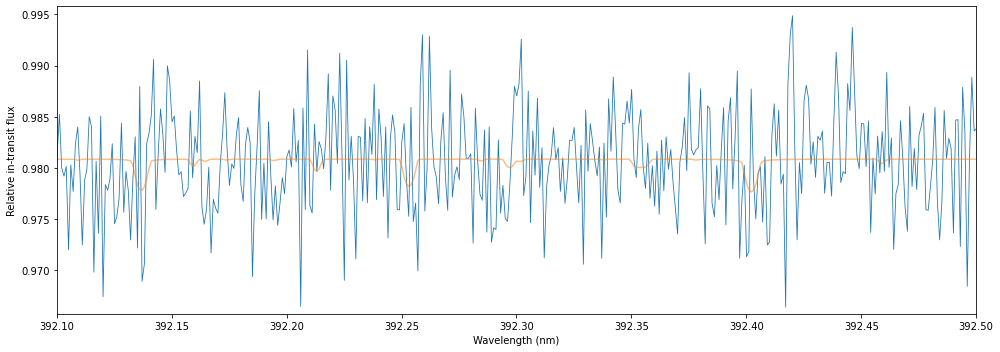

In [154]:
true_p = [2550.0,-5.1,0.3,-1.1,-2.0,-1.8,-2.1,1.0]#T, log(chi_fe), log(chi_ca/chi_fe), log(chi_ti/chi_fe), log(chi_v/chi_fe), log(chi_cr/chi_fe), k0, c. 

SNR = 200.0
x = wl
y1 = model_jax_adv(true_p,k_Fe_i,k_Ca_i,k_Ti_i,k_V_i,k_Cr_i)
yerr = 1.0/SNR
y = y1 + np.random.normal(scale=yerr, size=(len(x)))

yrange = np.max([3*yerr,np.abs(np.max(y1)-np.min(y1))])

plt.figure(figsize=(14,5))
plt.plot(x, y,linewidth=0.8)
plt.plot(x,y1,alpha=0.5)
plt.xlim(392.1,392.5)
plt.ylim(np.mean(y)-yrange,np.mean(y)+yrange)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative in-transit flux')
plt.tight_layout()
plt.show()

Now lets try a fit!

In [155]:
init_guess_adv = np.array([2500.0,-6.0,0.5,-1.0,-2.5,-2.0,-2.0,1.0])
bestp_jax_adv = minimize(chi2_jax_adv, init_guess_adv, args=(jnp.array(k_Fe_i),
                                                             jnp.array(k_Ca_i),
                                                             jnp.array(k_Ti_i),
                                                             jnp.array(k_V_i),
                                                             jnp.array(k_Cr_i), 
                                                             jnp.array(y), 
                                                             yerr), method='bfgs')

# print the best-fit parameters
print('Best fit:')
print(bestp_jax_adv.x)
print('True values:')
print(true_p)
print('Initial guess:')
print(init_guess_adv)

print('Did the fit succeed?!')
print(bestp_jax.success)

plt.figure(figsize=(14,5))
plt.plot(x, y,linewidth=0.8,color='black',label='Data',alpha=0.3)#This is the data
plt.plot(x,y1,alpha=1.0,label='True spectrum',color='darkgreen')
plt.plot(x,model_jax_adv(bestp_jax_adv.x, k_Fe_i,k_Ca_i,k_Ti_i,k_V_i,k_Cr_i),alpha=0.5,label='Best-fit',color='red')
plt.plot(x,model_jax_adv(init_guess_adv, k_Fe_i,k_Ca_i,k_Ti_i,k_V_i,k_Cr_i),alpha=0.5,label='Initial guess',color='navy',linestyle='--')
plt.xlim(392.1,391.5)
plt.ylim(np.mean(y)-yrange,np.mean(y)+yrange)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative in-transit flux');
plt.legend()
plt.tight_layout()
plt.show()

Best fit:
[ 2.5000688e+03  1.2824110e+02  3.6800884e+01  3.3420620e+01
  2.5734669e+01  4.7755122e-01 -1.3356699e+02  9.2282200e-01]
True values:
[2550.0, -5.1, 0.3, -1.1, -2.0, -1.8, -2.1, 1.0]
Initial guess:
[ 2.5e+03 -6.0e+00  5.0e-01 -1.0e+00 -2.5e+00 -2.0e+00 -2.0e+00  1.0e+00]
Did the fit succeed?!
False


Again, this looks like nothing because we have no priors.

In [158]:
def numpyro_model_adv():
    """
    Define a model to sample with the No U-Turn Sampler (NUTS) via numpyro.
    
    The two Gaussians are defined by an amplitude, mean, and standard deviation.
    
    To find unique solutions for the two Gaussians, we put non-overlapping bounded 
    priors on the two amplitudes, but vary the means and stddev's with identical 
    uniform priors. 
    """
    # Define a prior for the temperature:
    T_prior = numpyro.sample('T', dist.Uniform(low=1000, high=6000))
    
    # Uniform prior for log(chi_fe)
    chi_fe_prior = numpyro.sample(
        'log($\chi_{Fe}$)', dist.Uniform(low=-10, high=-3))
 
    # Uniform prior for log(chi_ca/chi_fe)
    chi_ca_prior = numpyro.sample(
        'log($\chi_{Ca}$ / $\chi_{Fe}$)', dist.Uniform(low=-3, high=1))

    # Uniform prior for log(chi_ti/chi_fe)
    chi_ti_prior = numpyro.sample(
        'log($\chi_{Ti}$ / $\chi_{Fe}$)', dist.Uniform(low=-4, high=0.5))

    # Uniform prior for log(chi_v/chi_fe)
    chi_v_prior = numpyro.sample(
        'log($\chi_{V}$ / $\chi_{Fe}$)', dist.Uniform(low=-5, high=-0.5))
    
    # Uniform prior for log(chi_cr/chi_fe)
    chi_cr_prior = numpyro.sample(
        'log($\chi_{Cr}$ / $\chi_{Fe}$)', dist.Uniform(low=-4, high=0.5))
    
    # Uniform prior for log(k0):
    k0_prior = numpyro.sample('log($\kappa_0$)', dist.Uniform(low=-5, high=0))

#     Uniform prior for log(k0):
#     c_prior = numpyro.sample('c', dist.Normal(loc=1.0, scale=0.001))
    c_prior = numpyro.sample('c', dist.Uniform(low=0.999, high=1.001))
    
    # Normally distributed likelihood
    numpyro.sample("obs", dist.Normal(loc=model_jax_adv([T_prior, chi_fe_prior, chi_ca_prior,
                                                         chi_ti_prior,  chi_v_prior,  
                                                         chi_cr_prior, k0_prior,c_prior], 
                                                        k_Fe_i,k_Ca_i,k_Ti_i,k_V_i,k_Cr_i),scale=yerr), obs=y)

In [ ]:
rng_seed = 42
rng_keys = split(PRNGKey(rng_seed),cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model_adv, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=500, 
    num_samples=6000, 
    num_chains=4
)

# Run the MCMC
mcmc.run(rng_keys)

# arviz converts a numpyro MCMC object to an `InferenceData` object based on xarray:
result = arviz.from_numpyro(mcmc)

# these are the inputs to the synthetic double-gaussian profile (blue lines)
truths = {'T': true_p[0], 
          'log($\chi_{Fe}$)': true_p[1], 
          'log($\chi_{Ca}$ / $\chi_{Fe}$)' : true_p[2],
          'log($\chi_{Ti}$ / $\chi_{Fe}$)' : true_p[2],
          'log($\chi_{V}$ / $\chi_{Fe}$)' : true_p[3],
          'log($\chi_{Cr}$ / $\chi_{Fe}$)' : true_p[4],
          'log($\kappa_0$)': true_p[5], 
          'c': true_p[6]}
# make a corner plot
corner(
    result, 
    quiet=True, 
    truths=truths
);

  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/6500 [00:00<?, ?it/s]

W0610 01:10:39.950175 140734981461440 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.
W0610 01:10:39.956090 140734981461440 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.
W0610 01:10:39.959733 140734981461440 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.
